# Text Preprocessing

In [2]:
import datetime

import pandas as pd
import spacy
import re
import string

from spacy.tokens import Token
from tqdm import tqdm

from textblob import TextBlob
from textblob import Word

import html

In [5]:
df = pd.read_csv("..//data//Womens Clothing E-Commerce Reviews.csv")
# Removed index from dataframe
df=df.drop(columns=["Unnamed: 0"])

## Outlier handling for Age Feature

0.995 percentile of age is 79.0


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


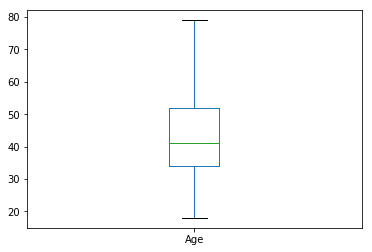

In [9]:
## Setting upper bound to 90 percentile data to avoid outlier in age.
thersold=.995
print(str(thersold)+" percentile of age is "+str(df["Age"].quantile(thersold)))

df["Age"][df["Age"] > df["Age"].quantile(thersold)]=df["Age"].quantile(thersold)

# Data are well distributed between Ages.
df["Age"].plot(kind="box");

## Removing Empty reviews

In [64]:
## Discarding a empty reviews records

df=df[((df["Review Text"].isna()==False) & (df["Review Text"]!=""))]

## Sample reviews

In [65]:
df['Review Text'].head(35).tail(5).tolist()

['Beautifully made pants and on trend with the flared crop. so much cuter in person. love these!',
 "I never would have given these pants a second look online, in person they are much cuter! the stripes are brighter and the fit more flattering. the crop has a cute flare which is right on trend. this brand has always run small for me, i am 5'8 about 140lbs and carry some chubbiness in the belly. i paired it with a collarless loose navy blazer",
 'These pants are even better in person. the only downside is that they need to be dry cleaned.',
 'I ordered this 3 months ago, and it finally came off back order. a huge disappointment. the fit wasn&#39;t so much the issue for me. the quality of the wool is subpar. someone else mentioned a &quot;felted wool&quot;...i guess, is that what you call it?  it does literally feel like felt! super thin, itchy, doesn&#39;t drape very well, and feels cheap (made in china). i got it on sale, but still not worth what i paid. definitely going back.',
 'This

## Formatting the HTML escape values

In [66]:
df["Review Text"]=df["Review Text"].apply(str).apply(html.unescape)

## Sample reviews (After Reformatting)

In [67]:
df['Review Text'].head(35).tail(5).tolist()

['Beautifully made pants and on trend with the flared crop. so much cuter in person. love these!',
 "I never would have given these pants a second look online, in person they are much cuter! the stripes are brighter and the fit more flattering. the crop has a cute flare which is right on trend. this brand has always run small for me, i am 5'8 about 140lbs and carry some chubbiness in the belly. i paired it with a collarless loose navy blazer",
 'These pants are even better in person. the only downside is that they need to be dry cleaned.',
 'I ordered this 3 months ago, and it finally came off back order. a huge disappointment. the fit wasn\'t so much the issue for me. the quality of the wool is subpar. someone else mentioned a "felted wool"...i guess, is that what you call it?  it does literally feel like felt! super thin, itchy, doesn\'t drape very well, and feels cheap (made in china). i got it on sale, but still not worth what i paid. definitely going back.',
 'This is such a neat 

## Text preprocessing

- Remove the digits, stopwords, punctuation and alpha numeric words
- Lemmatizing the words 
- removing new line in review

In [68]:
nlp = spacy.load("en_core_web_sm")

def remove_spell_errors(doc):
    bdoc = TextBlob(str(doc))
    ## Correcting the words
    return str(bdoc.correct())

def stop(doc):
    return [token for token in doc if not token.is_digit and not token.is_stop and ( token.text.isalpha() or not token.text.isalnum())]

def lemmatize(doc):
    return [token.lemma_.lower() if token.lemma_ != "-PRON-" else token.text.lower() for token in doc]

def remove_line_breaks(doc):
    return [token.replace("\n", " ").replace("\r", " ") for token in doc]

nlp.add_pipe(stop)
nlp.add_pipe(lemmatize)
nlp.add_pipe(remove_line_breaks)

In [69]:
print(str(datetime.datetime.now())+" : Started preprocessing")
#docs = df["Review Text"].apply(remove_spell_errors).to_list()
docs = df["Review Text"].apply(str).to_list()
processed_docs = []

with tqdm(total=len(docs)) as bar:
    for doc in nlp.pipe(docs):
            line = " ".join(doc)
            ## Removing the punctuation
            line=line.translate(str.maketrans('','',string.punctuation))
            ## Removing numbers 
            line=" ".join(list(filter(lambda w : not w.isdigit(), line.split())))
            processed_docs.append(line)
            bar.update(1)

df["processed_Review_text"] = processed_docs
print(str(datetime.datetime.now())+" : Preprocessing completed")

2019-09-08 18:39:07.845811 : Started preprocessing


100%|████████████████████████████████████| 22641/22641 [28:22<00:00, 13.30it/s]


2019-09-08 19:07:30.780603 : Preprocessing completed


## Experimented with Spell correction 

We tried to correct the wrong spelling words. But most of the review are having casual words which leads to wrong spell correction. So we did not implemented 

In [70]:
TextBlob("mom").words[0].spellcheck()

[('mon', 0.5094339622641509),
 ('mob', 0.24528301886792453),
 ('mot', 0.0660377358490566),
 ('mop', 0.04716981132075472),
 ('tom', 0.03773584905660377),
 ('com', 0.03773584905660377),
 ('nom', 0.018867924528301886),
 ('om', 0.009433962264150943),
 ('mo', 0.009433962264150943),
 ('mmm', 0.009433962264150943),
 ('mm', 0.009433962264150943)]

## After Preprocessed Output

In [71]:
df["Review Text"].tolist()[630:635]

["I don't normally try on tops like this but i liked the product shot so much that i wanted to repeat the outfit. i grabbed a large because it wasa shorter blouse. it was huge. i sized down to the medium and it was still loose but if i were to purchase, it would be that size. the red against the blue was very pretty but i didn't know if felt like a little kid in a uniform. the back did not lie flat, not sure if it was because of my 36d chest or because of the shirt design. it is well made and i th",
 'I love this ankle length pant. it is so comfortable wear it with a tunic or tee. i can wear this for 3 seasons!',
 'I think this is the first time i\'ve successfully purchased pants online. i normally have to try a bunch of styles and sizes on before i find the right ones. i gave it a shot with these, and bingo! they are great! they are a bit longer on me than on the model, because i am 5\'3" and did not order a petite. i still like how they look, hitting just above my ankle. just the rig

In [72]:
df["processed_Review_text"].tolist()[630:635]

['normally try top like like product shoot want repeat outfit grab large wasa short blouse huge size medium loose purchase size red blue pretty know feel like little kid uniform lie flat sure chest shirt design th',
 'love ankle length pant comfortable wear tunic tee wear season',
 'think time successfully purchase pant online normally try bunch style size find right one give shot bingo great bit longer model order petite like look hit ankle right blend conservative cool lecture college undergrad',
 'cute soft comfortable short wear night wear',
 'see email immediately go web look fit nice slim look leg fit little slimmer picture tight']

In [73]:
df.to_csv("..//data//Womens Clothing E-Commerce Reviews PreProcessed.csv", index=False)